In [17]:
import zipfile
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import string
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split


In [18]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
with zipfile.ZipFile("/content/flickr8k.zip", 'r') as zip_ref:
    zip_ref.extractall("flickr8k")

In [20]:
# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet')
# Create model by removing the final classification layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 149, 149, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 149, 149, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 147, 147, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 147, 147, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 147, 147, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 147, 147, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 147, 147, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 147, 147, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 73, 73, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 73, 73, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 73, 73, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [21]:
def preprocess_image(image_path):
    # Load and resize image to 299x299 (InceptionV3 requirement)
    img = load_img(image_path, target_size=(299, 299))
    # Convert to array
    img_array = img_to_array(img)
    # Expand dimensions for batch processing
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess input for InceptionV3
    img_array = preprocess_input(img_array)
    return img_array

In [22]:
def extract_features(image_paths):
    features = {}
    for image_path in image_paths:
        # Extract image ID from path
        image_id = os.path.split(image_path)[1]
        # Preprocess image
        img = preprocess_image(image_path)
        # Extract features
        feature = model.predict(img, verbose=0)
        # Reshape features to 1D vector
        feature = feature.reshape((2048,))
        # Store features with image ID as key
        features[image_id] = feature
    return features

# Save features
def save_features(features, filename):
    np.save(filename, features)

In [23]:
# Directory containing Flickr8k images
image_dir = '/content/flickr8k/Images'
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
print(len(image_paths))
# Extract features
features = extract_features(image_paths)

# Save features to disk
save_features(features, 'flickr8k_features.npy')

8091


In [24]:
def load_captions(captions_file):
    captions = {}

    with open(captions_file, 'r') as f:
        next(f)  # Skip the header line (image,caption)
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                try:
                    # Split by first comma
                    img_id, caption = line.split(',', 1)
                    # Add caption to list for this image ID
                    captions.setdefault(img_id, []).append(caption)
                except ValueError:
                    print(f"Warning: Skipping invalid line: {line}")

    return captions


def clean_captions(captions):
    # Initialize cleaned captions dictionary
    cleaned_captions = {}

    for img_id, caps in captions.items():
        cleaned_caps = []
        for cap in caps:
            # Convert to lowercase
            cap = cap.lower()
            # Remove special characters and numbers
            cap = ''.join([c for c in cap if c not in string.punctuation])
            cap = ''.join([c for c in cap if not c.isdigit()])
            # Remove extra spaces
            cap = ' '.join(cap.split())
            # Add start and end tokens
            cap = '<start> ' + cap + ' <end>'
            cleaned_caps.append(cap)
        cleaned_captions[img_id] = cleaned_caps
    return cleaned_captions

def build_vocabulary(cleaned_captions, threshold=5):
    # Count word frequencies
    word_counts = Counter()
    for img_id, caps in cleaned_captions.items():
        for cap in caps:
            word_counts.update(cap.split())

    # Create vocabulary with words above threshold
    vocabulary = [word for word, count in word_counts.items()
                 if count >= threshold]

    # Add special tokens if not already present
    # Moved this block *before* creating word_to_idx
    special_tokens = ['<start>', '<end>', '<unk>', '<pad>']
    for token in special_tokens:
        if token not in vocabulary:
            vocabulary.append(token)

    # Create word-to-index mapping
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

In [25]:
captions = load_captions('/content/flickr8k/captions.txt') # Load captions from file
print(f"Number of Captions: {len(captions)}")
cleaned_captions = clean_captions(captions) # Now pass the dictionary to clean_captions

# Build vocabulary
vocab, word_to_idx, idx_to_word = build_vocabulary(cleaned_captions, threshold=2)
#print(len(vocab))

Number of Captions: 8091


In [26]:
list(cleaned_captions.items())[:5]

[('1000268201_693b08cb0e.jpg',
  ['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
   '<start> a girl going into a wooden building <end>',
   '<start> a little girl climbing into a wooden playhouse <end>',
   '<start> a little girl climbing the stairs to her playhouse <end>',
   '<start> a little girl in a pink dress going into a wooden cabin <end>']),
 ('1001773457_577c3a7d70.jpg',
  ['<start> a black dog and a spotted dog are fighting <end>',
   '<start> a black dog and a tricolored dog playing with each other on the road <end>',
   '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>',
   '<start> two dogs of different breeds looking at each other on the road <end>',
   '<start> two dogs on pavement moving toward each other <end>']),
 ('1002674143_1b742ab4b8.jpg',
  ['<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <end>',
   '<start> a little girl

In [27]:
print(f"Number of images with captions: {len(captions)}")
# Print a few examples to verify
for image_id, caption_list in list(captions.items())[:5]:
    print(f"Image ID: {image_id} | Captions: {caption_list}")

Number of images with captions: 8091
Image ID: 1000268201_693b08cb0e.jpg | Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image ID: 1001773457_577c3a7d70.jpg | Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
Image ID: 1002674143_1b742ab4b8.jpg | Captions: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with 

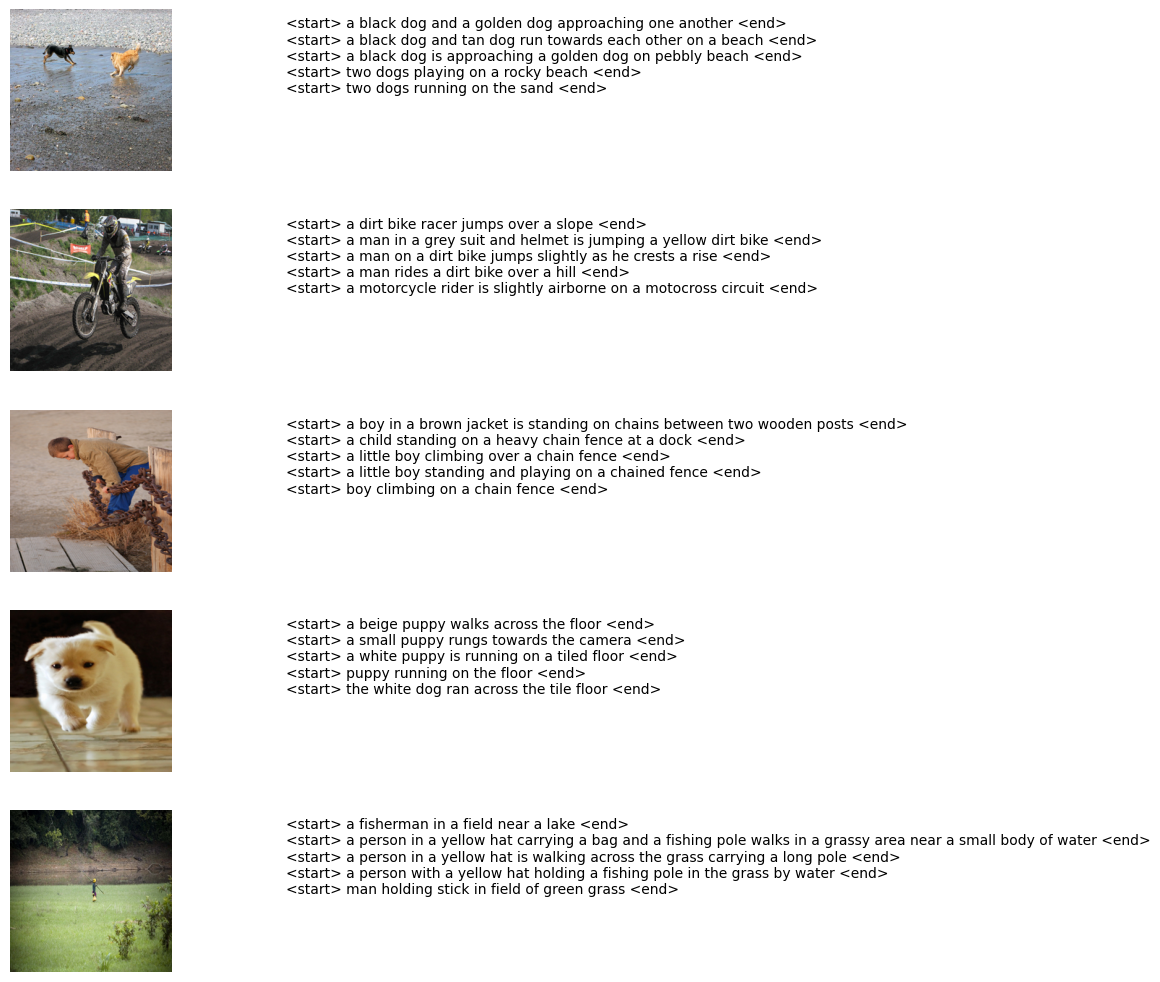

In [28]:
def display_random_images_captions(cleaned_captions, images_dir, num_samples=5):
    # Select random image-caption pairs
    random_pairs = random.sample(list(cleaned_captions.items()), num_samples)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 10))

    for idx, (image_id, captions) in enumerate(random_pairs, 1):
        # Load and display image
        image_path = os.path.join(images_dir, image_id)
        image = Image.open(image_path)
        image = image.resize((224, 224))  # Resize for display
        # Create subplot
        plt.subplot(num_samples, 2, (idx * 2) - 1)
        plt.imshow(image)
        plt.axis('off')

        # Display captions
        plt.subplot(num_samples, 2, idx * 2)
        plt.text(0, 0.5, '\n'.join(captions), wrap=True)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
images_dir = '/content/flickr8k/Images'
display_random_images_captions(cleaned_captions, images_dir)


In [29]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

16184

In [30]:
from sklearn.model_selection import train_test_split

# Get image IDs from the cleaned captions dictionary
image_ids = list(cleaned_captions.keys())

# Split image IDs into train and test sets
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create training and testing datasets
train_captions = {id: cleaned_captions[id] for id in train_ids}
test_captions = {id: cleaned_captions[id] for id in test_ids}

train_features = {id: features[id] for id in train_ids}
test_features = {id: features[id] for id in test_ids}

# Save the split datasets
os.makedirs('processed_data', exist_ok=True)
np.save('processed_data/train_captions.npy', train_captions)
np.save('processed_data/test_captions.npy', test_captions)
np.save('processed_data/train_features.npy', train_features)
np.save('processed_data/test_features.npy', test_features)

In [31]:
len(train_captions), len(test_captions)

(6472, 1619)

In [45]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import gc  # Garbage collector

def build_caption_generator(vocab_size, max_length, embedding_dim=256, rnn_units=512):
    """Build the caption generator model"""
    # Image feature input
    image_input = Input(shape=(2048,))

    # Caption input
    caption_input = Input(shape=(max_length,))

    # Feature encoder
    image_features = Dense(embedding_dim)(image_input)

    # Word embedding layer
    embed = Embedding(vocab_size,
                     embedding_dim,
                     mask_zero=True)(caption_input)

    # LSTM layer
    initial_h = Dense(rnn_units)(image_features)  # For LSTM hidden state
    initial_c = Dense(rnn_units)(image_features)  # For LSTM cell state

    lstm = LSTM(
        rnn_units,
        return_sequences=False, # Changed to return_sequences=False
        dropout=0.5
    )(embed, initial_state=[initial_h, initial_c])


    # Dense layer for word prediction
    dense = Dense(vocab_size, activation='softmax')(lstm)

    # Create and compile model
    model = Model(inputs=[image_input, caption_input], outputs=dense)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )

    return model

# Training setup
def train_model(train_captions, train_features, word_to_idx,
                max_length=40, batch_size=32, epochs=5):
    """Train the caption generator model"""

    # Model parameters
    vocab_size = len(word_to_idx)
    embedding_dim = 256
    rnn_units = 512

    # Build model
    model = build_caption_generator(
        vocab_size,
        max_length,
        embedding_dim,
        rnn_units
    )

    # Create generator
    train_generator = data_generator(
        train_captions,
        train_features,
        word_to_idx,
        max_length,
        batch_size
    )

    # Calculate steps per epoch
    steps_per_epoch = sum(len(caps) for caps in train_captions.values()) // batch_size

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )

    return model, history

In [46]:
def data_generator(captions_dict, features_dict, word_to_idx, max_length, batch_size):
    image_ids = list(captions_dict.keys())
    while True:
        np.random.shuffle(image_ids)
        for i in range(0, len(image_ids), batch_size):
            batch_ids = image_ids[i:i + batch_size]
            batch_X1, batch_X2, batch_y = [], [], []

            for img_id in batch_ids:
                caption = np.random.choice(captions_dict[img_id])
                seq = ['<start>'] + caption.split() + ['<end>']
                seq = [word_to_idx.get(word, word_to_idx['<unk>']) for word in seq]

                for j in range(1, len(seq)):
                    in_seq = seq[:j]
                    out_seq = seq[j]
                    in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]

                    batch_X1.append(features_dict[img_id])
                    batch_X2.append(in_seq)
                    batch_y.append(out_seq)

            yield (tf.convert_to_tensor(batch_X1), tf.convert_to_tensor(batch_X2)), tf.convert_to_tensor(batch_y)

In [47]:
def generate_caption(model, image_features, word_to_idx, idx_to_word, max_length):
    input_text = ['<start>']
    for _ in range(max_length):
        sequence = [word_to_idx.get(word, word_to_idx['<unk>']) for word in input_text]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)[0]

        yhat = model.predict([np.array([image_features]), np.array([sequence])], verbose=0)
        word_idx = np.argmax(yhat[0, -1])
        word = idx_to_word[word_idx]

        # Skip repeated predictions of `<start>`
        if word == '<start>' and len(input_text) > 1:
            continue

        if word == '<end>':
            break

        input_text.append(word)

    return ' '.join(input_text[1:-1])

In [48]:
# Training setup
def train_model(train_captions, train_features, word_to_idx,
                max_length=40, batch_size=32, epochs=5):
    """Train the caption generator model"""

    # Model parameters
    vocab_size = len(word_to_idx)
    embedding_dim = 256
    rnn_units = 512

    # Build model
    model = build_caption_generator(
        vocab_size,
        max_length,
        embedding_dim,
        rnn_units
    )

    # Create generator
    train_generator = data_generator(
        train_captions,
        train_features,
        word_to_idx,
        max_length,
        batch_size
    )

    # Calculate steps per epoch
    steps_per_epoch = sum(len(caps) for caps in train_captions.values()) // batch_size

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        verbose=1
    )

    return model, history

In [49]:
max_length = 40
batch_size = 32
epochs = 5

# Train model
model, history = train_model(
        train_captions,
        train_features,
        word_to_idx,
        max_length,
        batch_size,
        epochs
    )

# Save model
model.save('caption_generator_model.keras')

Epoch 1/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 119s 116ms/step - accuracy: 0.3421 - loss: 3.6975
Epoch 2/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 119s 117ms/step - accuracy: 0.3983 - loss: 2.9047
Epoch 3/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 116s 115ms/step - accuracy: 0.4081 - loss: 2.7760
Epoch 4/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 115s 114ms/step - accuracy: 0.4099 - loss: 2.7217
Epoch 5/5
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 116s 114ms/step - accuracy: 0.4135 - loss: 2.6739


In [50]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [51]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "<start>"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == '<end>':
            break

    return in_text